# HW: X-ray images classification
--------------------------------------

Before you begin, open Mobaxterm and connect to triton with the user and password you were give with. Activate the environment `2ndPaper` and then type the command `pip install scikit-image`.

In this assignment you will be dealing with classification of 32X32 X-ray images of the chest. The image can be classified into one of four options: lungs (l), clavicles (c), and heart (h) and background (b). Even though those labels are dependent, we will treat this task as multiclass and not as multilabel. The dataset for this assignment is located on a shared folder on triton (`/MLdata/MLcourse/X_ray/'`).

In [1]:
!which python

/opt/miniconda3/envs/2ndPaper-t2/bin/python


In [2]:
import os
import numpy as np
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Dropout
from tensorflow.keras.layers import Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *

from tensorflow.keras.initializers import Constant
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from skimage.io import imread

from skimage.transform import rescale, resize, downscale_local_mean
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="2"

/home/smorandv/anaconda3/envs/2ndPaper-t2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/smorandv/anaconda3/envs/2ndPaper-t2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/smorandv/anaconda3/envs/2ndPaper-t2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/smorandv/anaconda3/

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
def preprocess(datapath):
    # This part reads the images
    classes = ['b','c','l','h']
    imagelist = [fn for fn in os.listdir(datapath)]
    N = len(imagelist)
    num_classes = len(classes)
    images = np.zeros((N, 32, 32, 1))
    Y = np.zeros((N,num_classes))
    ii=0
    for fn in imagelist:

        src = imread(os.path.join(datapath, fn),1)
        img = resize(src,(32,32),order = 3)
        
        images[ii,:,:,0] = img
        cc = -1
        for cl in range(len(classes)):
            if fn[-5] == classes[cl]:
                cc = cl
        Y[ii,cc]=1
        ii += 1

    BaseImages = images
    BaseY = Y
    return BaseImages, BaseY

In [5]:
def preprocess_train_and_val(datapath):
    # This part reads the images
    classes = ['b','c','l','h']
    imagelist = [fn for fn in os.listdir(datapath)]
    N = len(imagelist)
    num_classes = len(classes)
    images = np.zeros((N, 32, 32, 1))
    Y = np.zeros((N,num_classes))
    ii=0
    for fn in imagelist:

        images[ii,:,:,0] = imread(os.path.join(datapath, fn),1)
        cc = -1
        for cl in range(len(classes)):
            if fn[-5] == classes[cl]:
                cc = cl
        Y[ii,cc]=1
        ii += 1

    return images, Y

In [6]:
#Loading the data for training and validation:
src_data = '/MLdata/MLcourse/X_ray/'
train_path = src_data + 'train'
val_path = src_data + 'validation'
test_path = src_data + 'test'
BaseX_train , BaseY_train = preprocess_train_and_val(train_path)
BaseX_val , BaseY_val = preprocess_train_and_val(val_path)
X_test, Y_test = preprocess(test_path)

In [7]:
keras.backend.clear_session()

### PART 1: Fully connected layers 
--------------------------------------

---
<span style="color:red">***Task 1:***</span> *NN with fully connected layers. 

Elaborate a NN with 2 hidden fully connected layers with 300, 150 neurons and 4 neurons for classification. Use ReLU activation functions for the hidden layers and He_normal for initialization. Don't forget to flatten your image before feedforward to the first dense layer. Name the model `model_relu`.*

---

In [8]:
#--------------------------Impelment your code here:-------------------------------------
model_relu = Sequential()
model_relu.add(Flatten(input_shape=(32,32,1)))
model_relu.add(Dense(300,kernel_initializer="he_normal", name='he_normal1'))
model_relu.add(Dense(150, activation='relu', name='Relu_1'))
model_relu.add(Dense(4, activation='relu', name='Relu_2'))
model_relu.add(Activation('softmax'))
#----------------------------------------------------------------------------------------

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model_relu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
he_normal1 (Dense)           (None, 300)               307500    
_________________________________________________________________
Relu_1 (Dense)               (None, 150)               45150     
_________________________________________________________________
Relu_2 (Dense)               (None, 4)                 604       
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 353,254
Trainable params: 353,254
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Inputs: 
input_shape = (32,32,1)
learn_rate = 1e-5
decay = 0
batch_size = 64
epochs = 25

#Define your optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)


Compile the model with the optimizer above, accuracy metric and adequate loss for multiclass task. Train your model on the training set and evaluate the model on the testing set. Print the accuracy and loss over the testing set.

In [11]:
#--------------------------Impelment your code here:-------------------------------------
model_relu.compile(optimizer=AdamOpt,metrics=['accuracy'], loss='binary_crossentropy')
history_relu = model_relu.fit(BaseX_train, BaseY_train, batch_size = batch_size, epochs = epochs, validation_data = (BaseX_val,BaseY_val))
y_pred_test = model_relu.predict(X_test)
loss_and_acc = model_relu.evaluate(X_test, Y_test, batch_size=batch_size)
print("[test loss, test accuracy]:", loss_and_acc)
#----------------------------------------------------------------------------------------

Train on 6474 samples, validate on 1728 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
6474/6474 [==============================] - 1s 220us/sample - loss: 0.5342 - acc: 0.7586 - val_loss: 0.5001 - val_acc: 0.7726
Epoch 2/25
6474/6474 [==============================] - 1s 110us/sample - loss: 0.4821 - acc: 0.7778 - val_loss: 0.4685 - val_acc: 0.7834
Epoch 3/25
6474/6474 [==============================] - 1s 103us/sample - loss: 0.4507 - acc: 0.7892 - val_loss: 0.4351 - val_acc: 0.7993
Epoch 4/25
6474/6474 [==============================] - 1s 108us/sample - loss: 0.4231 - acc: 0.8063 - val_loss: 0.4145 - val_acc: 0.8170
Epoch 5/25
6474/6474 [==============================] - 1s 111us/sample - loss: 0.4047 - acc: 0.8181 - val_loss: 0.3990 - val_acc: 0.8296
Epoch 6/25
6474/6474 [==============================] - 1s 114us/sample - loss: 0.3913 - acc: 0.8278 - val_loss: 0.3877 - val_acc: 0.8352
Epoch 7/25
6474/6474 [==============================] - 1s 111us/sample - lo

---
<span style="color:red">***Task 2:***</span> *Activation functions.* 

Change the activation functions to LeakyRelu or tanh or sigmoid. Name the new model `new_a_model`. Explain how it can affect the model.*

---

In [12]:
#--------------------------Impelment your code here:-------------------------------------
new_a_model = Sequential()
new_a_model.add(Flatten(input_shape=(32,32,1)))
new_a_model.add(Dense(300, kernel_initializer="he_normal"))
new_a_model.add(Dense(150, activation='tanh'))
new_a_model.add(Dense(4, activation='tanh'))
new_a_model.add(Activation('softmax'))
#----------------------------------------------------------------------------------------

In [13]:
new_a_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               307500    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 604       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 353,254
Trainable params: 353,254
Non-trainable params: 0
_________________________________________________________________


---
<span style="color:red">***Task 3:***</span> *Number of epochs.* 

Train the new model using 25 and 40 epochs. What difference does it makes in term of performance? Remember to save the compiled model for having initialized weights for every run as we did in tutorial 12. Evaluate each trained model on the test set*

---

In [14]:
#Inputs: 
input_shape = (32,32,1)
learn_rate = 1e-5
decay = 0
batch_size = 64
epochs = 25

#Defining the optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)



In [15]:
#--------------------------Impelment your code here:-------------------------------------
new_a_model.compile(optimizer=AdamOpt,metrics=['accuracy'], loss='binary_crossentropy')
history_a_model = new_a_model.fit(BaseX_train, BaseY_train, batch_size = batch_size, epochs = epochs, validation_data = (BaseX_val,BaseY_val))
y_pred_test = new_a_model.predict(X_test)
loss_and_acc = new_a_model.evaluate(X_test, Y_test, batch_size=batch_size)
print("[test loss, test accuracy]:", loss_and_acc)
#-----------------------------------------------------------------------------------------

Train on 6474 samples, validate on 1728 samples
Epoch 1/25
6474/6474 [==============================] - 1s 142us/sample - loss: 0.5197 - acc: 0.7532 - val_loss: 0.4834 - val_acc: 0.7662
Epoch 2/25
6474/6474 [==============================] - 1s 105us/sample - loss: 0.4693 - acc: 0.7731 - val_loss: 0.4536 - val_acc: 0.7880
Epoch 3/25
6474/6474 [==============================] - 1s 108us/sample - loss: 0.4462 - acc: 0.7894 - val_loss: 0.4367 - val_acc: 0.7962
Epoch 4/25
6474/6474 [==============================] - 1s 109us/sample - loss: 0.4305 - acc: 0.7996 - val_loss: 0.4240 - val_acc: 0.8044
Epoch 5/25
6474/6474 [==============================] - 1s 118us/sample - loss: 0.4186 - acc: 0.8068 - val_loss: 0.4144 - val_acc: 0.8122
Epoch 6/25
6474/6474 [==============================] - 1s 115us/sample - loss: 0.4095 - acc: 0.8157 - val_loss: 0.4070 - val_acc: 0.8210
Epoch 7/25
6474/6474 [==============================] - 1s 115us/sample - loss: 0.4018 - acc: 0.8241 - val_loss: 0.4003 - va

In [16]:
#Inputs: 
input_shape = (32,32,1)
learn_rate = 1e-5
decay = 0
batch_size = 64
epochs = 40

#Defining the optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)



In [17]:
#--------------------------Impelment your code here:-------------------------------------
new_a_model.compile(optimizer=AdamOpt,metrics=['accuracy'], loss='binary_crossentropy')
history = new_a_model.fit(BaseX_train, BaseY_train, batch_size = batch_size, epochs = epochs, validation_data = (BaseX_val,BaseY_val))
y_pred_test = new_a_model.predict(X_test)
loss_and_acc = new_a_model.evaluate(X_test, Y_test, batch_size=batch_size)
print("[test loss, test accuracy]:", loss_and_acc)
#-----------------------------------------------------------------------------------------

Train on 6474 samples, validate on 1728 samples
Epoch 1/40
6474/6474 [==============================] - 1s 165us/sample - loss: 0.3375 - acc: 0.8840 - val_loss: 0.3424 - val_acc: 0.8801
Epoch 2/40
6474/6474 [==============================] - 1s 112us/sample - loss: 0.3352 - acc: 0.8859 - val_loss: 0.3407 - val_acc: 0.8841
Epoch 3/40
6474/6474 [==============================] - 1s 109us/sample - loss: 0.3334 - acc: 0.8870 - val_loss: 0.3395 - val_acc: 0.8870
Epoch 4/40
6474/6474 [==============================] - 1s 112us/sample - loss: 0.3313 - acc: 0.8887 - val_loss: 0.3384 - val_acc: 0.8828
Epoch 5/40
6474/6474 [==============================] - 1s 117us/sample - loss: 0.3299 - acc: 0.8887 - val_loss: 0.3354 - val_acc: 0.8872
Epoch 6/40
6474/6474 [==============================] - 1s 110us/sample - loss: 0.3279 - acc: 0.8906 - val_loss: 0.3349 - val_acc: 0.8880
Epoch 7/40
6474/6474 [==============================] - 1s 112us/sample - loss: 0.3261 - acc: 0.8912 - val_loss: 0.3324 - va

In [18]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

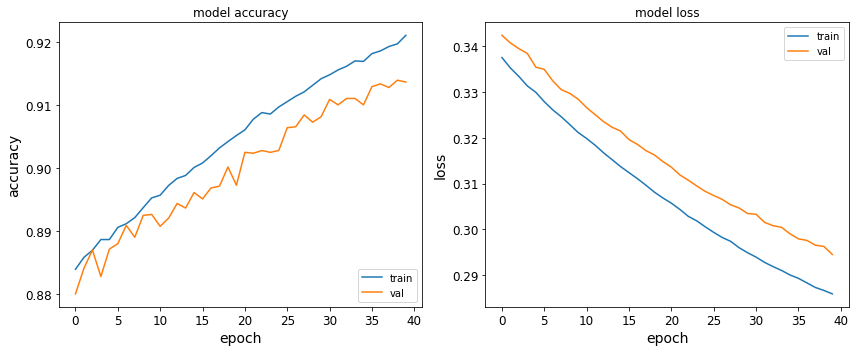

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='lower right')


axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.tight_layout()

---
<span style="color:red">***Task 4:***</span> *Mini-batches.* 

Build the `model_relu` again and run it with a batch size of 32 instead of 64. What are the advantages of the mini-batch vs. SGD?*

---

In [20]:
keras.backend.clear_session()

In [21]:
#--------------------------Impelment your code here:-------------------------------------
model_relu = Sequential()
model_relu.add(Flatten(input_shape=(32,32,1)))
model_relu.add(Dense(300,kernel_initializer="he_normal"))
model_relu.add(Dense(150, activation='relu'))
model_relu.add(Dense(4, activation='relu'))
model_relu.add(Activation('softmax'))
#----------------------------------------------------------------------------------------

In [22]:
batch_size = 32
epochs = 50

#Define your optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)


In [23]:
#--------------------------Impelment your code here:-------------------------------------
model_relu.compile(optimizer=AdamOpt,metrics=['accuracy'], loss='binary_crossentropy')
history_relu = model_relu.fit(BaseX_train, BaseY_train, batch_size = batch_size, epochs = epochs, validation_data = (BaseX_val,BaseY_val))
y_pred_test = model_relu.predict(X_test)
loss_and_acc = model_relu.evaluate(X_test, Y_test, batch_size=batch_size)
print("[test loss, test accuracy]:", loss_and_acc)
#----------------------------------------------------------------------------------------

Train on 6474 samples, validate on 1728 samples
Epoch 1/50
6474/6474 [==============================] - 2s 242us/sample - loss: 0.5429 - acc: 0.7553 - val_loss: 0.5200 - val_acc: 0.7643
Epoch 2/50
6474/6474 [==============================] - 1s 206us/sample - loss: 0.5133 - acc: 0.7685 - val_loss: 0.5020 - val_acc: 0.7802
Epoch 3/50
6474/6474 [==============================] - 1s 209us/sample - loss: 0.4986 - acc: 0.7792 - val_loss: 0.4911 - val_acc: 0.7852
Epoch 4/50
6474/6474 [==============================] - 1s 208us/sample - loss: 0.4882 - acc: 0.7881 - val_loss: 0.4815 - val_acc: 0.7977
Epoch 5/50
6474/6474 [==============================] - 1s 203us/sample - loss: 0.4797 - acc: 0.7956 - val_loss: 0.4747 - val_acc: 0.8002
Epoch 6/50
6474/6474 [==============================] - 1s 209us/sample - loss: 0.4721 - acc: 0.8009 - val_loss: 0.4677 - val_acc: 0.8056
Epoch 7/50
6474/6474 [==============================] - 1s 213us/sample - loss: 0.4659 - acc: 0.8051 - val_loss: 0.4618 - va

---
<span style="color:red">***Task 4:***</span> *Batch normalization.* 

Build the `new_a_model` again and add batch normalization layers. How does it impact your results?*

---

In [24]:
keras.backend.clear_session()

In [25]:
#--------------------------Impelment your code here:-------------------------------------
new_a_model = Sequential()
new_a_model.add(Flatten(input_shape=(32,32,1)))
new_a_model.add(Dense(300,kernel_initializer="he_normal"))
new_a_model.add(BatchNormalization())
new_a_model.add(Dense(150, activation='sigmoid'))
new_a_model.add(BatchNormalization())
new_a_model.add(Dense(4, activation='sigmoid'))
new_a_model.add(BatchNormalization())
new_a_model.add(Activation('softmax'))
#---------------------------------------------------------------------------------------

In [26]:
batch_size = 32
epochs = 50

#Define your optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)
#Compile the network: 


In [27]:
#Preforming the training by using fit 
#--------------------------Impelment your code here:-------------------------------------
new_a_model.compile(optimizer=AdamOpt,metrics=['accuracy'], loss='binary_crossentropy')
history = new_a_model.fit(BaseX_train, BaseY_train, batch_size=batch_size, epochs=epochs, validation_data = (BaseX_val,BaseY_val))
y_pred_test = new_a_model.predict(X_test)
loss_and_acc = new_a_model.evaluate(X_test, Y_test, batch_size=batch_size)
print("[test loss, test accuracy]:", loss_and_acc)
#----------------------------------------------------------------------------------------

Train on 6474 samples, validate on 1728 samples
Epoch 1/50
6474/6474 [==============================] - 3s 447us/sample - loss: 0.4532 - acc: 0.7974 - val_loss: 0.4974 - val_acc: 0.7494
Epoch 2/50
6474/6474 [==============================] - 2s 359us/sample - loss: 0.3624 - acc: 0.8520 - val_loss: 0.3755 - val_acc: 0.8471
Epoch 3/50
6474/6474 [==============================] - 2s 355us/sample - loss: 0.3361 - acc: 0.8689 - val_loss: 0.3421 - val_acc: 0.8730
Epoch 4/50
6474/6474 [==============================] - 2s 364us/sample - loss: 0.3230 - acc: 0.8767 - val_loss: 0.3137 - val_acc: 0.8876
Epoch 5/50
6474/6474 [==============================] - 2s 356us/sample - loss: 0.3130 - acc: 0.8842 - val_loss: 0.3022 - val_acc: 0.8957
Epoch 6/50
6474/6474 [==============================] - 2s 359us/sample - loss: 0.3044 - acc: 0.8899 - val_loss: 0.3010 - val_acc: 0.8951
Epoch 7/50
6474/6474 [==============================] - 2s 357us/sample - loss: 0.2982 - acc: 0.8942 - val_loss: 0.2870 - va

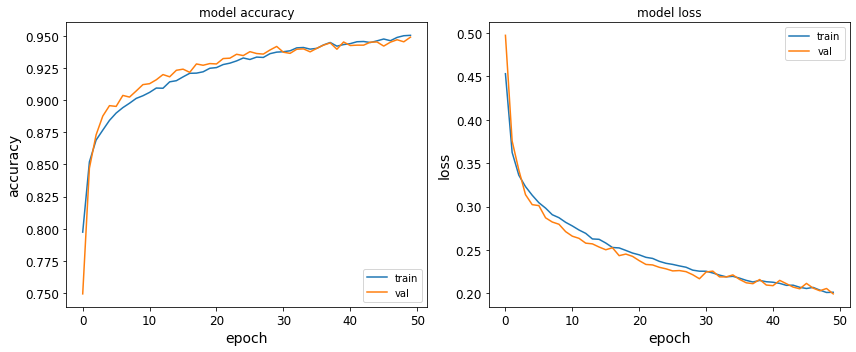

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='lower right')


axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.tight_layout()

### PART 2: Convolutional Neural Network (CNN)
------------------------------------------------------------------------------------

---
<span style="color:red">***Task 1:***</span> *2D CNN.* 

Have a look at the model below and answer the following:
* How many layers does it have?
* How many filter in each layer?
* Would the number of parmaters be similar to a fully connected NN?
* Is this specific NN performing regularization?

---

In [29]:
def get_net(input_shape,drop,dropRate,reg):
    #Defining the network architecture:
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = input_shape))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_1',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_2',kernel_regularizer=regularizers.l2(reg)))
    if drop:    
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_3',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_4',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_5',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    #Fully connected network tail:      
    model.add(Dense(512, activation='elu',name='FCN_1')) 
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(Dense(128, activation='elu',name='FCN_2'))
    model.add(Dense(4, activation= 'softmax',name='FCN_3'))
    model.summary()
    return model

In [30]:
input_shape = (32,32,1)
learn_rate = 1e-5
decay = 1e-03
batch_size = 64
epochs = 25
drop = True
dropRate = 0.3
reg = 1e-2
NNet = get_net(input_shape,drop,dropRate,reg)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 32, 32, 1)         0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 32, 32, 64)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 16, 16, 128)       73856     
___________________________

In [31]:
NNet=get_net(input_shape,drop,dropRate,reg)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 32, 32, 1)         0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 32, 32, 64)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
__________

In [32]:
from tensorflow.keras.optimizers import *
import os
from tensorflow.keras.callbacks import *

#Defining the optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)

#Compile the network: 
NNet.compile(optimizer=AdamOpt, metrics=['acc'], loss='categorical_crossentropy')

#Saving checkpoints during training:
Checkpath = os.getcwd()
Checkp = ModelCheckpoint(Checkpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)

In [33]:
#Preforming the training by using fit 
# IMPORTANT NOTE: This will take a few minutes!
h = NNet.fit(x=BaseX_train, y=BaseY_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0, validation_data = (BaseX_val, BaseY_val), shuffle=True)
#NNet.save(model_fn)

Train on 6474 samples, validate on 1728 samples
Epoch 1/25
6474/6474 [==============================] - 5s 758us/sample - loss: 7.9283 - acc: 0.4445 - val_loss: 8.0354 - val_acc: 0.2500
Epoch 2/25
6474/6474 [==============================] - 2s 350us/sample - loss: 7.5191 - acc: 0.5565 - val_loss: 8.2667 - val_acc: 0.2500
Epoch 3/25
6474/6474 [==============================] - 2s 353us/sample - loss: 7.3680 - acc: 0.5910 - val_loss: 8.3179 - val_acc: 0.2546
Epoch 4/25
6474/6474 [==============================] - 2s 352us/sample - loss: 7.2625 - acc: 0.6398 - val_loss: 8.3713 - val_acc: 0.2679
Epoch 5/25
6474/6474 [==============================] - 2s 348us/sample - loss: 7.1669 - acc: 0.6532 - val_loss: 8.2432 - val_acc: 0.3223
Epoch 6/25
6474/6474 [==============================] - 2s 352us/sample - loss: 7.0901 - acc: 0.6792 - val_loss: 8.0273 - val_acc: 0.3339
Epoch 7/25
6474/6474 [==============================] - 2s 347us/sample - loss: 7.0339 - acc: 0.6905 - val_loss: 7.8442 - va

In [34]:
# NNet.load_weights('Weights_1.h5')

In [35]:
results = NNet.evaluate(X_test,Y_test)
print('test loss, test acc:', results)

175/175 [==============================] - 0s 458us/sample - loss: 7.9460 - acc: 0.2743
test loss, test acc: [7.945970437186105, 0.2742857]


---
<span style="color:red">***Task 2:***</span> *Number of filters* 

Rebuild the function `get_net` to have as an input argument a list of number of filters in each layers, i.e. for the CNN defined above the input should have been `[64, 128, 128, 256, 256]`. Now train the model with the number of filters reduced by half. What were the results.

---

In [37]:
#--------------------------Impelment your code here:-------------------------------------
def get_net1(input_shape,drop,dropRate,reg):
    #Defining the network architecture:
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_1',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_2',kernel_regularizer=regularizers.l2(reg)))
    if drop:    
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_3',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_4',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu',name='Conv2D_5',kernel_regularizer=regularizers.l2(reg)))
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    #Fully connected network tail:      
    model.add(Dense(512, activation='elu',name='FCN_1')) 
    if drop:
        model.add(Dropout(rate=dropRate))
    model.add(Dense(128, activation='elu',name='FCN_2'))
    model.add(Dense(4, activation= 'softmax',name='FCN_3'))
    model.summary()
    return model

input_shape = (32,32,1)
learn_rate = 1e-5
decay = 1e-03
batch_size = 64
epochs = 25
drop = True
dropRate = 0.3
reg = 1e-2
NNet_new = get_net1(input_shape,drop,dropRate,reg)

#Defining the optimizar parameters:
AdamOpt = Adam(lr=learn_rate,decay=decay)

#Compile the network: 
NNet_new.compile(optimizer=AdamOpt, metrics=['acc'], loss='categorical_crossentropy')

#Saving checkpoints during training:
Checkpath = os.getcwd()
Checkp = ModelCheckpoint(Checkpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
h = NNet_new.fit(x=BaseX_train, y=BaseY_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0, validation_data = (BaseX_val, BaseY_val), shuffle=True)
results = NNet_new.evaluate(X_test,Y_test)
print('test loss, test acc:', results)
#----------------------------------------------------------------------------------------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 32, 32, 1)         0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_v1_18 (B (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 16, 64)        0         
__________

That's all folks! See you :)